In this sset of notebooks, I will be exploring model interpretation. I will be using the CT images from the RICORD Database, the links for which and data processing can be found in the corresponding notebook. 
This notebook will be exploring grad-CAM with a smaller portion of the dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from random import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import pydicom


Similar to what we did in our image conversion notebook, we will first make a list of all our PNG images

In [2]:
neg_dir='D:\\tensorflow_datasets\\covid-CT\\negative\\images'
pos_dir='D:\\tensorflow_datasets\\covid-CT\positive\\images'

# Get the list of all files in directory tree at given path
def buildList(directoryPath):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(directoryPath):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    return listOfFiles

In [3]:
positive_files=buildList(pos_dir)
negative_files=buildList(neg_dir)

Now we can verify our data - it should look the same as in our conversion notebook

In [4]:
print('negative file example: ', negative_files[0])
print('positive file example: ', positive_files[0])
print('\n')
print('# of negative results: ', len(negative_files))
print('# of positive results: ', len(positive_files))
print('total images: ', len(negative_files)+len(positive_files))

print('positive:negative ratio: ', len(positive_files)/len(negative_files))

negative file example:  D:\tensorflow_datasets\covid-CT\negative\images\img0.png
positive file example:  D:\tensorflow_datasets\covid-CT\positive\images\img0.png


# of negative results:  21220
# of positive results:  31856
total images:  53076
positive:negative ratio:  1.501225259189444


Now let's read a single DICOM image to test, and output the image array that we will be using. We aren't going to be using the other info attached to the dicom images - we only want the images themselves. We can use pydicom to read the images, and with numpy installed we can convert the pixel array to an ndarray

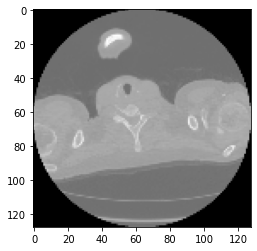

In [5]:
img=cv2.imread(negative_files[0])
plt.imshow(img)


In [6]:
def buildSet(fileList, label):
    i=0
    data_df=[]
    for f in fileList: 
        path = f
        img = cv2.imread(f)
        data_df.append([np.array(img), label, path])
        i+=1
    shuffle(data_df)
    return data_df

Now let's build our sets. This will take a while since we are reading all of the images 1-by-1

For now, we will use a small subset to make sure our code works, then run it again with the whole directory. 

In [7]:
class_info={0: 'COVID-negative', 1:'COVID-positive'}

positive_set = buildSet(positive_files[0:500],1)
negative_set = buildSet(negative_files[0:500],0)

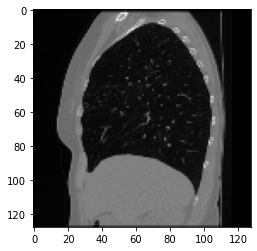

In [57]:
# make sure the images are still accessible - they are stored in a df so we need to acces the 
    #first element of the first array
plt.imshow(positive_set[0][0])

Now we should merge the positive and negative test images, and build our x_train and y_train set. 

In [58]:
xtrain_positives = np.array([i[0] for i in positive_set])
xtrain_negatives = np.array([i[0] for i in negative_set])
X = np.concatenate((xtrain_positives,xtrain_negatives))

ytrain_negatives= np.array([i[1] for i in negative_set])
ytrain_positives= np.array([i[1] for i in positive_set])
y = np.concatenate((ytrain_positives,ytrain_negatives))

In [59]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [62]:
X.shape
#shape should be (nsamples,image_height,image_width,depth)

(1000, 128, 128, 3)

In [22]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=2, activation="relu")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="2dcnn")
    return model

#use the shape from above here (last 3 values)
model = make_model(input_shape=(128,128,3))
model.summary()

Model: "2dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 31, 31, 64)        256   

In [63]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [64]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [65]:
y_train.shape

(800,)

In [66]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=val_split)

train_data = datagen.flow(X, y, subset = 'training')
val_data = datagen.flow(X,y,subset= 'validation')  


In [85]:
train_data

In [68]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
    
model.fit(train_data, validation_data=val_data, epochs=epochs,callbacks=[checkpoint_cb, early_stopping_cb])

'''model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.10,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)'''


Epoch 1/50
25/25 [==============================] - 2s 39ms/step - loss: 0.5284 - acc: 0.7188 - val_loss: 0.8554 - val_acc: 0.4700
Epoch 2/50
25/25 [==============================] - 1s 30ms/step - loss: 0.4204 - acc: 0.8125 - val_loss: 0.7190 - val_acc: 0.4700
Epoch 3/50
25/25 [==============================] - 1s 29ms/step - loss: 0.3616 - acc: 0.8350 - val_loss: 0.7090 - val_acc: 0.4700
Epoch 4/50
25/25 [==============================] - 1s 29ms/step - loss: 0.2927 - acc: 0.9013 - val_loss: 0.5827 - val_acc: 0.5650
Epoch 5/50
25/25 [==============================] - 1s 30ms/step - loss: 0.2513 - acc: 0.9187 - val_loss: 0.6273 - val_acc: 0.4700
Epoch 6/50
25/25 [==============================] - 1s 29ms/step - loss: 0.2030 - acc: 0.9513 - val_loss: 0.5261 - val_acc: 0.6350
Epoch 7/50
25/25 [==============================] - 1s 29ms/step - loss: 0.1691 - acc: 0.9575 - val_loss: 0.5597 - val_acc: 0.5900
Epoch 8/50
25/25 [==============================] - 1s 29ms/step - loss: 0.1354 - a

'model.fit(\n    x=x_train,\n    y=y_train,\n    validation_split=0.10,\n    epochs=epochs,\n    shuffle=True,\n    verbose=2,\n    callbacks=[checkpoint_cb, early_stopping_cb],\n)'

0


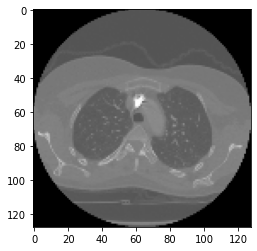

In [73]:
img = X[0]
print(y[0])
plt.imshow(img)

0
1


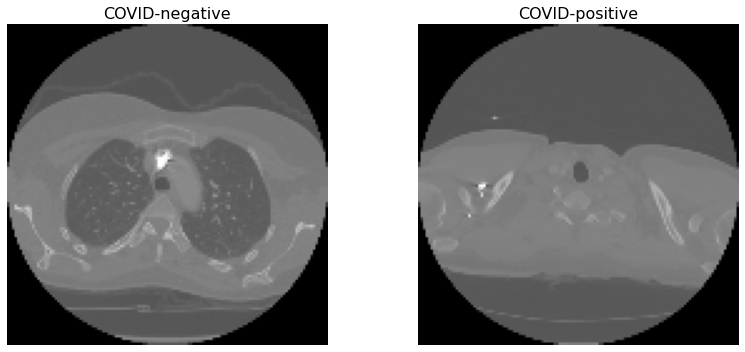

In [78]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.vgg16 import preprocess_input




img1=X[0]
print(y[0])
img2=X[1]
print(y[1])

images = np.asarray([img1, img2])

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, title in enumerate(image_titles):
    ax[i].set_title(class_info[y[i]], fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [74]:
images.shape

(2, 128, 128, 3)

In [77]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
    pred = tf.where(pred < 0.5, 0, 1)
    return pred.numpy()

img = X[0]
label = y[0]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]

pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

print('true label: ',label, '\n', 'Prediction: ', pred_label, pred_raw)


true label:  0 
 Prediction:  COVID-negative 0.001507478


In [79]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
                model.output])
    
    with tf.GradientTape() as tape:
# cast the image tensor to a float-32 data type, pass the
# image through the gradient model, and grab the loss
# associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

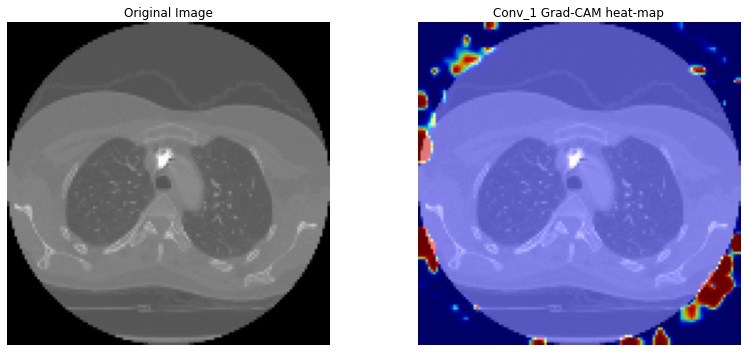

In [81]:
layer_name = 'conv2d_10'
img = X[0]
label = y[0]

grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img,)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

Well this is odd! The model seems to be weighing the outer parts of the image, which in this case contains nothing. Before we make any inferences, let's see what the gradCAM looks like in the next convolutional layer.

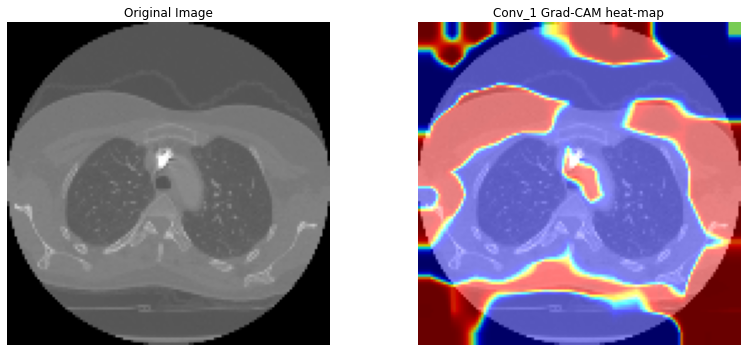

In [133]:
layer_name = 'conv2d_11'
img = X[0]
label = y[0]

grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img,)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

This looks more meaningful. We can see areas in this image that seem to have more importance. A ct scan is composed of slices of xrays, this specific image is a portion of the chest cavity. The patient is laying down with the top of their head in the center of the image. The small dark circle in the midle is the trachea, and the bigger ones on the left and right are the lungs. Considering this, it's interesting that the lungs aren't weighed much. let's look at the other layers now. 

In [92]:
conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
conv2D_layers

['conv2d_11', 'conv2d_10', 'conv2d_9', 'conv2d_8']

In [94]:
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers

['conv2d_11', 'conv2d_10', 'conv2d_9', 'conv2d_8']

In [104]:
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4]
all_layers

['batch_normalization_11',
 'max_pooling2d_11',
 'conv2d_11',
 'batch_normalization_10',
 'max_pooling2d_10',
 'conv2d_10',
 'batch_normalization_9',
 'max_pooling2d_9',
 'conv2d_9',
 'batch_normalization_8',
 'max_pooling2d_8',
 'conv2d_8']

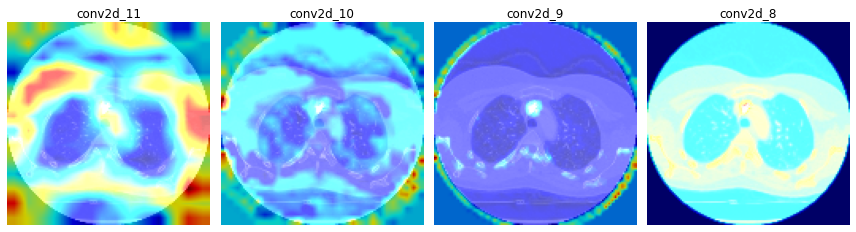

In [120]:
img = X[0]


plt.figure(figsize=(12,12))
for i, layer in enumerate(activation_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(1,4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()


These are some pretty interesting results! But here I've only included the convolution layers. So, lets look at ALL of the layers (that are valid)

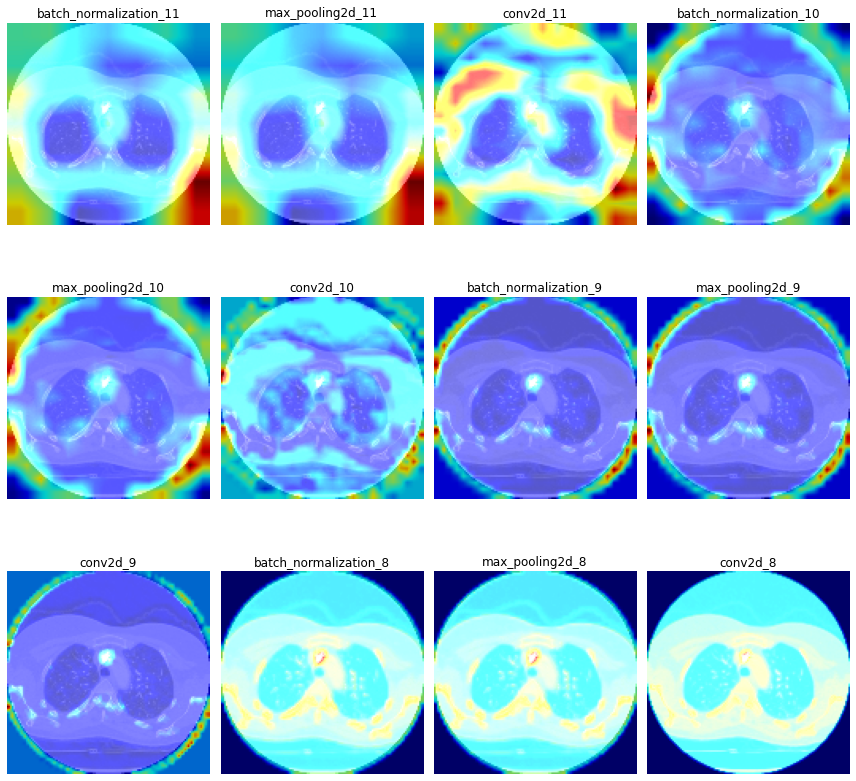

In [119]:
img = X[0]


plt.figure(figsize=(12, 12))
for i, layer in enumerate(all_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(3, 4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

These are some interesting results. There are different types of images, such as ones where the patient is upright and facing the camera, so we can see that the model detects which 'type' of scan each image is by looking at the bounds. It seems to also look at the throat area as well as the tissue around the lungs.

Let's look at another type of CT

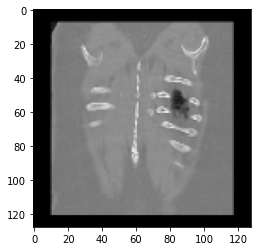

In [122]:
img2=X[201]
plt.imshow(img2)

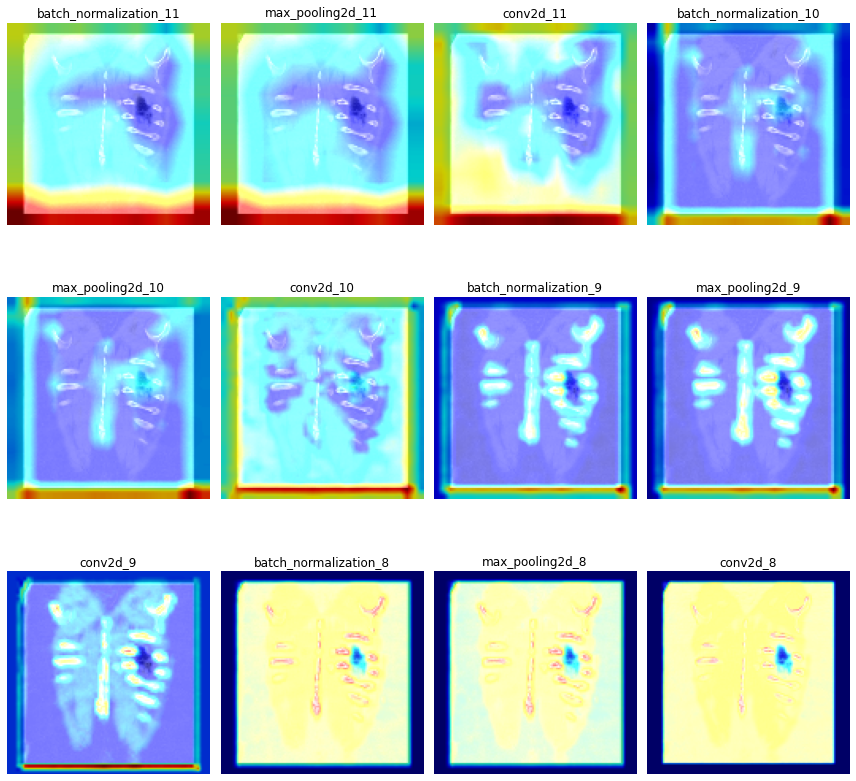

In [123]:
plt.figure(figsize=(12, 12))
for i, layer in enumerate(all_layers):
    grad_cam = GradCam(model, np.expand_dims(img2, axis=0), layer)
    grad_cam_emphasized = superimpose(img2, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(3, 4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

In [124]:
y[201]

1

It's interesting to see the areas that the model is highlighting for the different images. In the second image, that dark spot where the lung would be is the primary indicator for covid (lesion/scar tissue). So, the model might be looking at the last few laayers inversely (the areas not highlighted are what would be of concern to a doctor looking at this image). 

Lastly, lets create a fused grad-cam for all of the layers combined

In [134]:
'''  
Fuses grad-cam heatmaps from a list of model layers into a single heatmap
and superimposes the heatmap onto an image.

Args:
  layers: list of strings
  model: tf model
  img: (img_width x img_height x 3) numpy array


Returns 
  uint8 numpy array with shape (img_height, img_width, 3)

'''
def fuse_layers(layers, model, img, emphasize=False):
    cams = []
    for layer in layers:
        cam = GradCam(model, np.expand_dims(img, axis=0), layer)
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
        cams.append(cam)

    fused = np.mean(cams, axis=0)
    superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

    return superimposed

In [135]:
fused = fuse_layers(all_layers, model, img, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

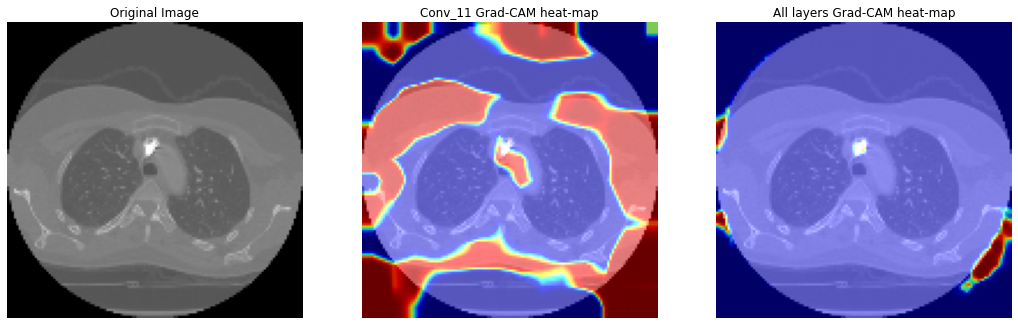

In [136]:
plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_11 Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

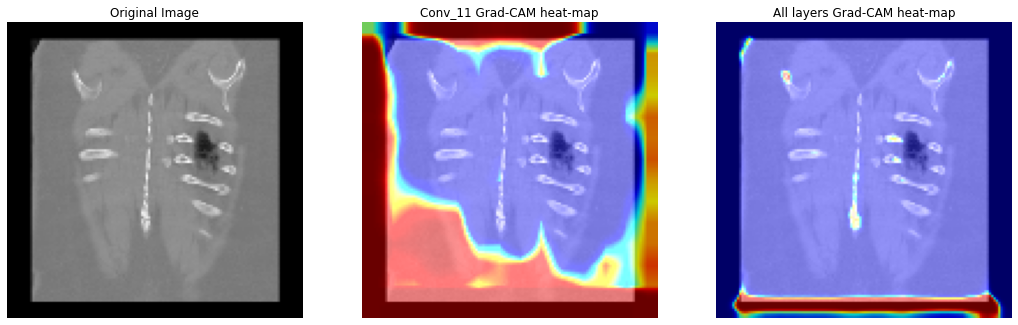

In [138]:
grad_cam2=GradCam(model,np.expand_dims(img2, axis=0),layer_name)
grad_cam_superimposed2 = superimpose(img2, grad_cam2, 0.5, emphasize=True)
fused2 = fuse_layers(all_layers, model, img2, True)

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title('Conv_11 Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused2)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')

The first image for the two sets above is the original, followed by a single convolutional layer, followed by the combined. When I look at the fused gradCam, the areas that are red (which should be the 'most important' for this heatmap) don't really correspond to anything particularly important, aside from maybe identifying which type of ct (ie the first being supine chest cavity, the other being upright)